## importing libraries

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Importing Dataset

In [2]:
log_dir="./logs"

In [3]:
train_dir = './data/train/'
test_dir = './data/test/'

## Creating Training and test Data

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=128,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=128,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [6]:
from glob import glob

angrypath = glob('./data/train/angry/*.jpg')
happypath = glob('./data/train/happy/*.jpg')
fearpath = glob('./data/train/fear/*.jpg')
disgustpath = glob('./data/train/disgust/*.jpg')
neutralpath = glob('./data/train/disgust/*.jpg')
sadpath = glob('./data/train/sad/*.jpg')
surprisepath = glob('./data/train/surprise/*.jpg')


angrypathtest = glob('./data/test/angry/*.jpg')
happypathtest = glob('./data/test/happy/*.jpg')
fearpathtest = glob('./data/test/fear/*.jpg')
disgustpathtest = glob('./data/test/disgust/*.jpg')
neutralpathtest = glob('./data/test/disgust/*.jpg')
sadpathtest = glob('./data/test/sad/*.jpg')
surprisepathtest = glob('./data/test/surprise/*.jpg')

In [8]:
len(angrypath + angrypathtest)

4953

In [9]:
len(happypath + happypathtest)

8989

In [10]:
len(fearpath + fearpathtest)

5121

In [11]:
len(disgustpath + disgustpathtest)

547

In [12]:
len(neutralpath + neutralpathtest)

547

In [13]:
len(sadpath + sadpathtest)

6077

In [14]:
len(surprisepath + surprisepathtest)

4002

In [15]:
path = angrypath + happypath + fearpath + disgustpath + neutralpath + sadpath + surprisepath
len(path)

24180

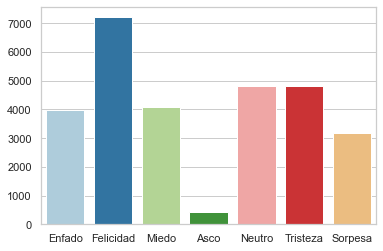

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
langs = ['Enfado', 'Felicidad', 'Miedo', 'Asco', 'Neutro', 'Tristeza', 'Sorpesa']
students = [len(angrypath), len(happypath), len(fearpath), len(disgustpath), len(sadpath), len(sadpath), len(surprisepath)]
ax = sns.barplot(x=langs, y=students, palette = 'Paired')

In [18]:
# Load the TensorBoard notebook extension
log_dir="./logs"

In [7]:
import pydot
import graphviz
from tensorflow.keras.utils import plot_model

## Defining Model

2022-04-15 16:59:10.658246: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 256)       2

2022-04-15 16:59:11.310442: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-15 16:59:11.310480: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-15 16:59:11.312031: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


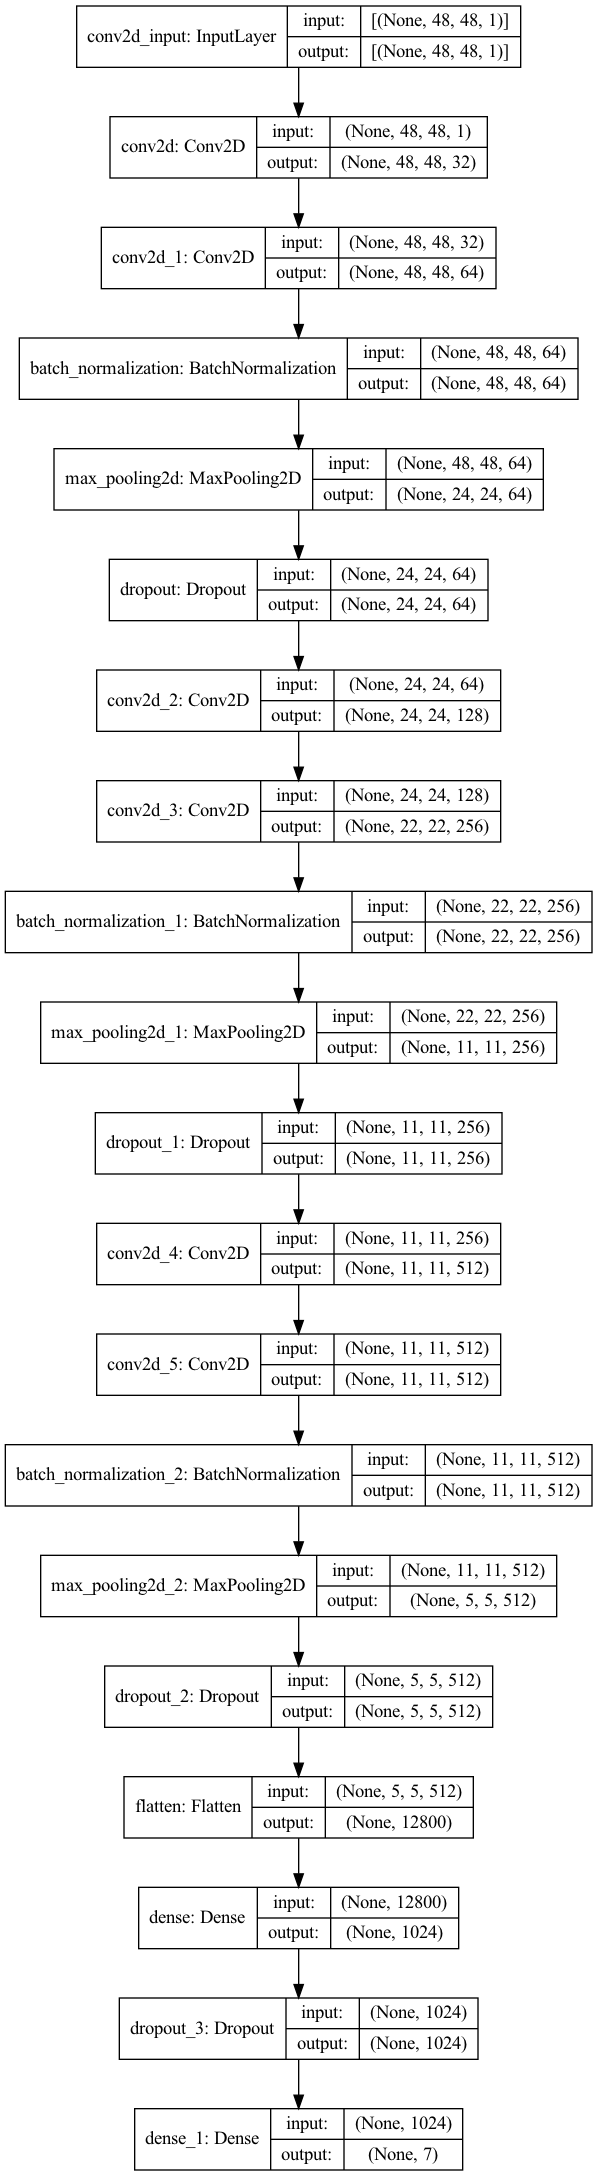

In [8]:
model = tf.keras.models.Sequential()   

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25)) 

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
    
model.add(Dense(7, activation='softmax'))

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

model.summary()

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6),loss='categorical_crossentropy',
              metrics=METRICS)

tf.keras.utils.plot_model(
     model,
     to_file="model_FER.png",
     show_shapes=True,
     show_layer_names=True,
     rankdir="TB",
     expand_nested=True,
     dpi=96,
 )

In [12]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [10]:
earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)

callbacks = [reduce_lr, tensorboard_callback]

## Training Model

In [11]:
hist = model.fit(x=training_set,
                 validation_data=test_set,
                 epochs=100,
                 callbacks=callbacks,
                 )

2022-04-15 17:00:55.844505: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
  1/225 [..............................] - ETA: 32:21 - loss: 16.1916 - accuracy: 0.1094 - precision: 0.1165 - recall: 0.0938 - auc: 0.4482

2022-04-15 17:01:04.685309: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-15 17:01:04.685328: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/225 [..............................] - ETA: 34:07 - loss: 16.5565 - accuracy: 0.1406 - precision: 0.1462 - recall: 0.1211 - auc: 0.4769

2022-04-15 17:01:13.789269: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-15 17:01:13.811907: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-15 17:01:13.839043: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_04_15_17_01_13

2022-04-15 17:01:13.845432: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2022_04_15_17_01_13/MacBook-Air-de-Maria.local.trace.json.gz
2022-04-15 17:01:13.870361: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_04_15_17_01_13

2022-04-15 17:01:13.870663: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2022_04_15_17_01_13/MacBook-Air-de-Maria.local.memory_profile.j

225/225 [==============================] - 1712s 8s/step - loss: 12.5413 - accuracy: 0.2544 - precision: 0.2652 - recall: 0.0385 - auc: 0.6532 - val_loss: 21.7908 - val_accuracy: 0.0155 - val_precision: 0.0155 - val_recall: 0.0155 - val_auc: 0.4257
Epoch 2/100
225/225 [==============================] - 1660s 7s/step - loss: 10.5563 - accuracy: 0.3092 - precision: 0.5708 - recall: 0.0535 - auc: 0.7114 - val_loss: 11.6636 - val_accuracy: 0.1597 - val_precision: 0.1691 - val_recall: 0.1498 - val_auc: 0.5230
Epoch 3/100
225/225 [==============================] - 2252s 10s/step - loss: 8.7287 - accuracy: 0.3422 - precision: 0.6384 - recall: 0.0935 - auc: 0.7399 - val_loss: 8.3340 - val_accuracy: 0.3559 - val_precision: 0.4107 - val_recall: 0.2452 - val_auc: 0.7211
Epoch 4/100
225/225 [==============================] - 3686s 16s/step - loss: 7.1240 - accuracy: 0.3710 - precision: 0.6766 - recall: 0.1188 - auc: 0.7600 - val_loss: 6.3803 - val_accuracy: 0.4216 - val_precision: 0.5789 - val_rec

KeyboardInterrupt: 

In [115]:
model.save_weights('./FER2013_model_weights.h5')

# final accuracy on test_set = 69.64 %

## Metrics plot

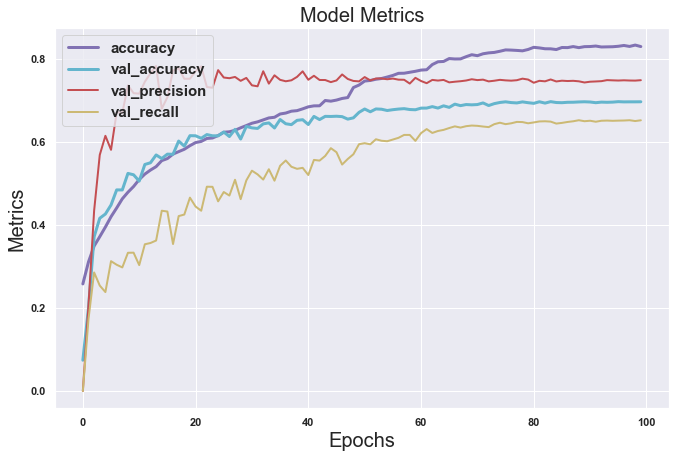

In [216]:
import matplotlib.pyplot as plt
import matplotlib
plt.figure(figsize=(11,7))
plt.plot(hist.history['accuracy'], color='m', linewidth=3.0)
plt.plot(hist.history['val_accuracy'], color='c',linewidth=3.0 )
plt.plot(hist.history['val_precision'], color='r',linewidth=2.0 )
plt.plot(hist.history['val_recall'], color='y',linewidth=2.0 )
plt.title('Model Metrics',fontsize = 20 )
plt.ylabel('Metrics',fontsize = 20)
plt.xlabel('Epochs',fontsize = 20)
plt.legend(['accuracy', 'val_accuracy','val_precision','val_recall'], loc='upper left',fontsize = 15)
plt.show()


# Confusion matrix on test_set

In [221]:
# first run the cnn model cell.

In [5]:
model.load_weights('./FER2013_model_weights.h5')

In [7]:
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
labels = ['angry','disgust','fear','happy','neutral','sad','surprise']
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(test_set.classes, y_pred)

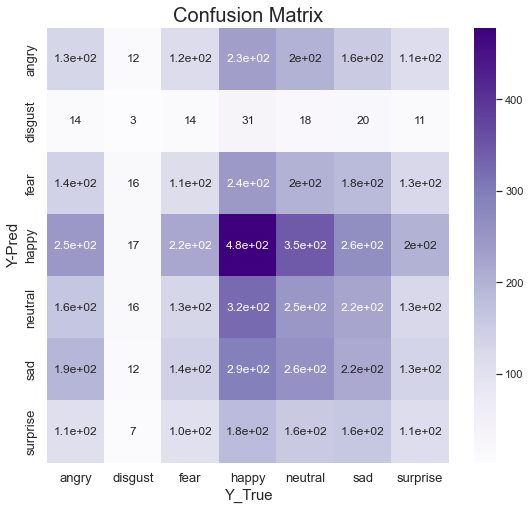

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
DetaFrame_cm = pd.DataFrame(cm, range(7), range(7))
p = sns.heatmap(DetaFrame_cm , cmap='Purples', annot=True)
p.set_title("Confusion Matrix",fontsize = 20)
sns.set(rc = {'figure.figsize':(10,9)})
sns.set(font_scale = 1)
p.set_yticklabels(labels, size = 13)
p.set_xticklabels(labels, size = 13)
p.set_xlabel("Y_True", fontsize = 15)
p.set_ylabel("Y-Pred", fontsize = 15)
plt.show()

# train and test data distributions.

<AxesSubplot:>

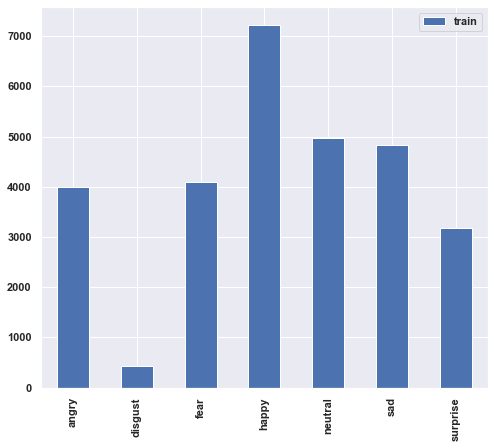

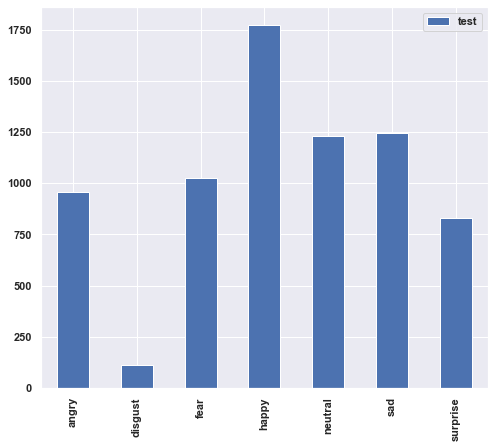

In [224]:
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
train_count.transpose().plot(kind='bar')
test_count.transpose().plot(kind='bar')